In [1]:
from visTools_v2.core_functions.operations.recursive_connected_components import connect,collect_masks

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import sys
sys.setrecursionlimit(15000)

In [3]:
def load_img(img,size=(300,300)):
    im = Image.open(img)
    im = im.resize((size[0],size[1]),Image.ANTIALIAS)
    im = np.array(im)
    plt.imshow(im)
    plt.show()
    im = np.moveaxis(im,2,0)
    im = np.mean(im,axis=0)/255
    im = im[np.newaxis,np.newaxis,:,:]
    return im

## Group connected items

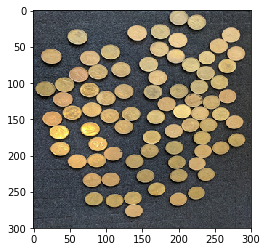

HBox(children=(IntProgress(value=0, max=300), HTML(value='')))

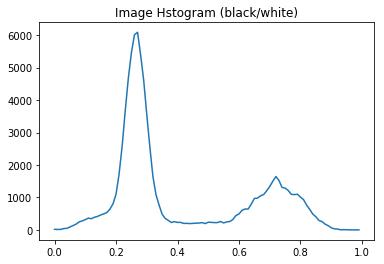

In [4]:
im = load_img('img/coins1.jpg')
labelled = connect(im,plot=True)

In [5]:
masks = collect_masks(labelled)

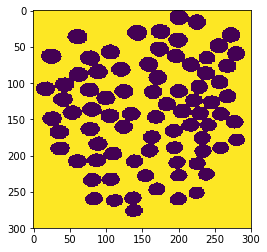

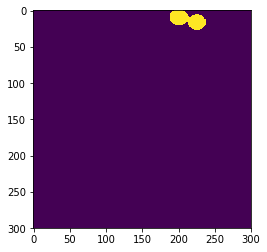

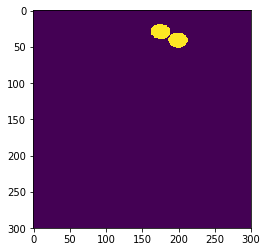

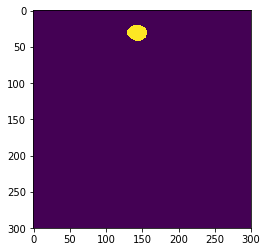

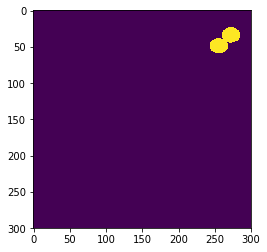

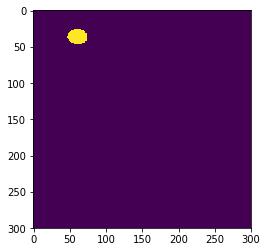

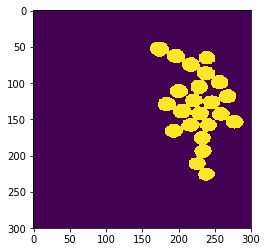

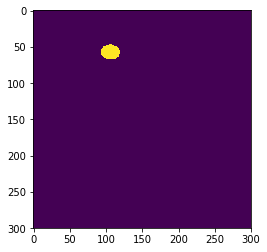

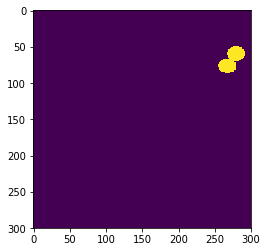

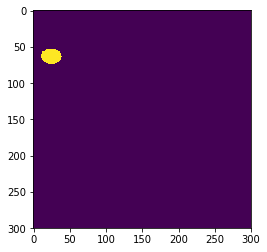

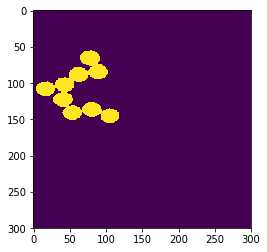

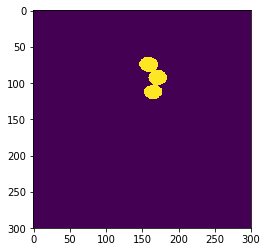

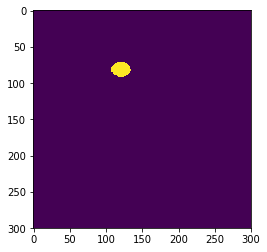

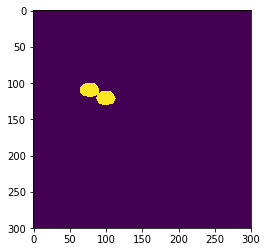

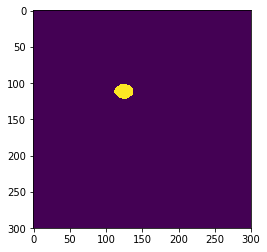

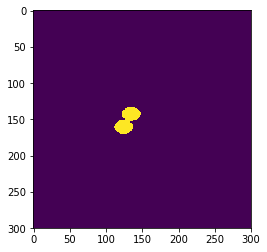

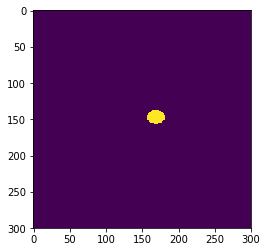

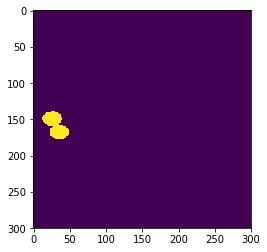

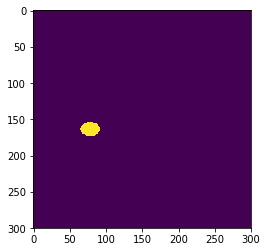

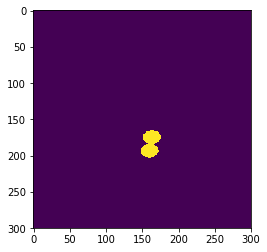

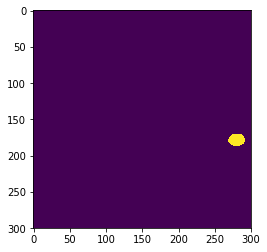

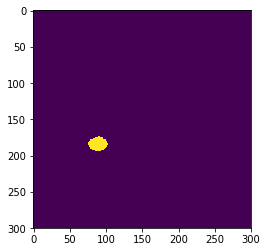

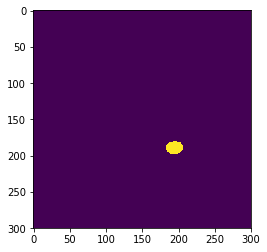

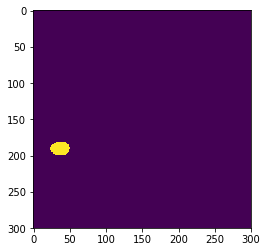

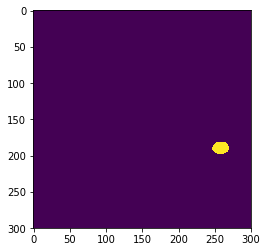

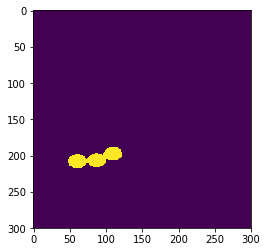

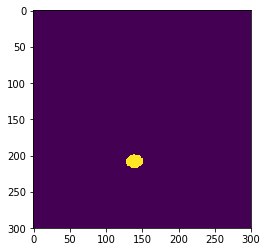

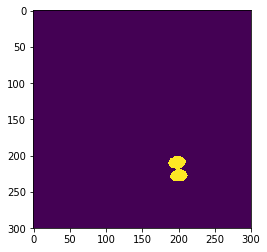

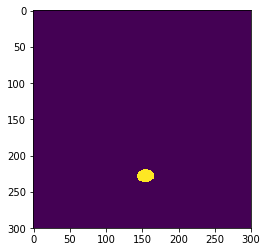

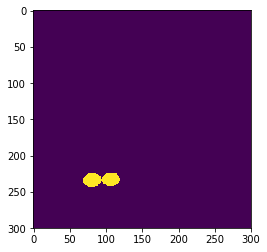

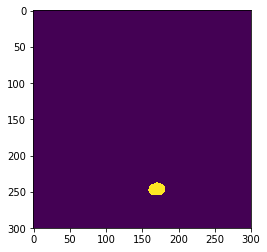

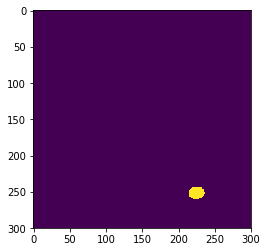

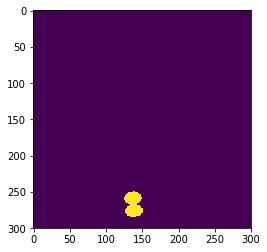

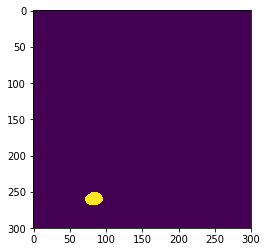

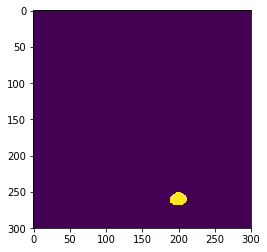

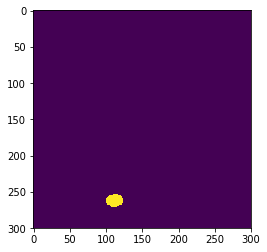

In [6]:
for i in range(len(masks)):
    plt.imshow(masks[i])
    plt.show()

## Extract img gradients

In [7]:
from visTools_v2.core_functions.edges import canny

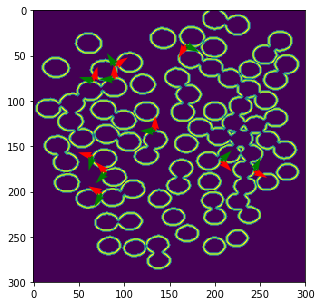

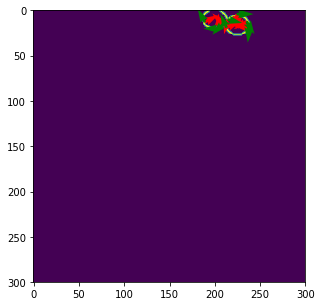

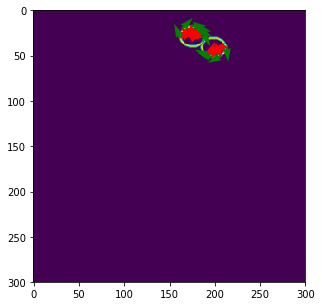

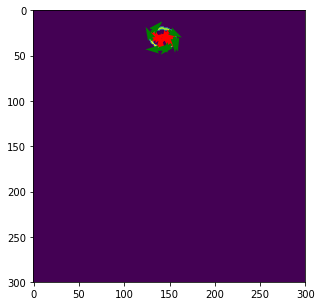

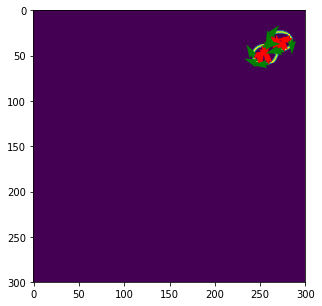

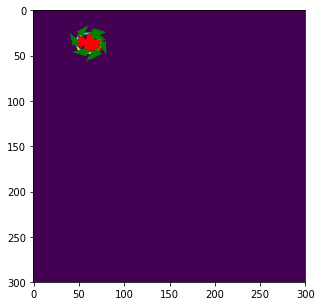

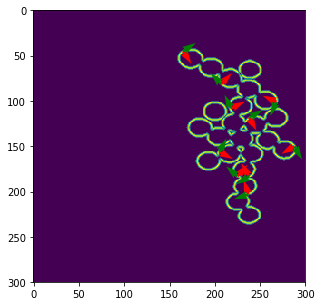

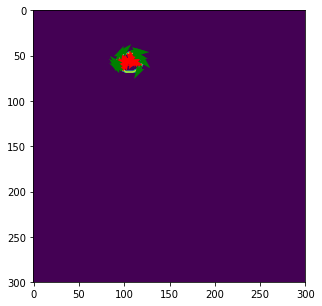

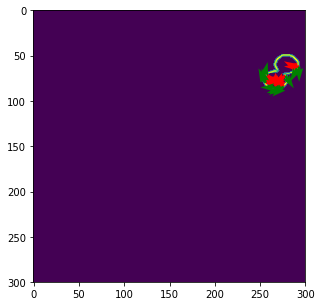

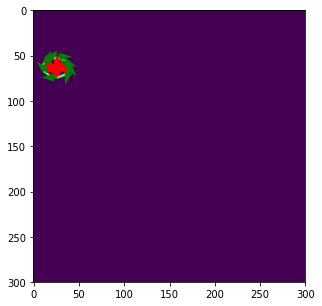

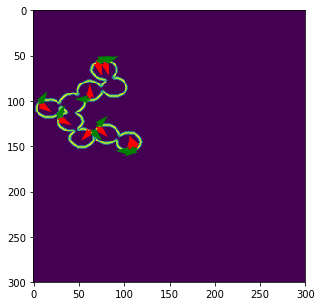

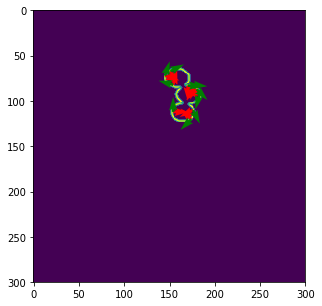

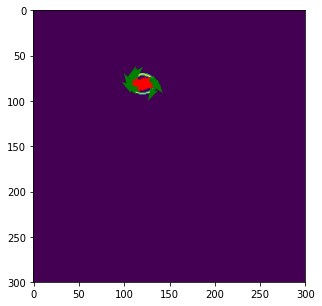

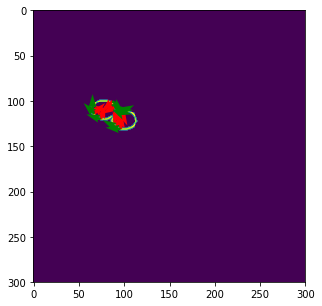

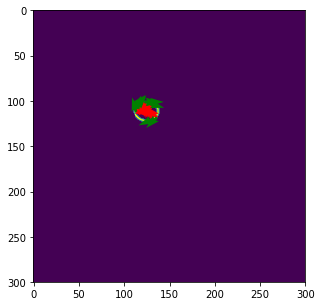

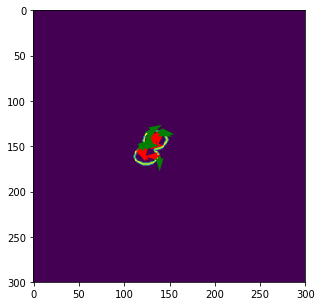

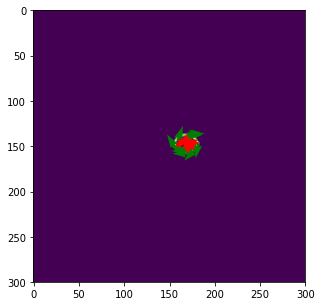

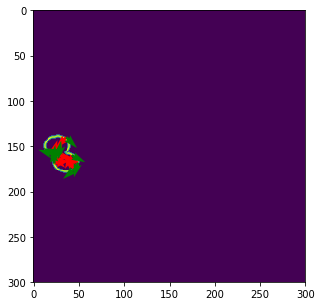

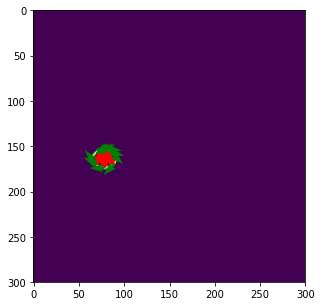

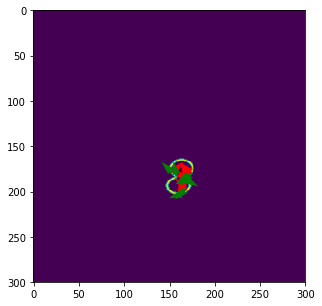

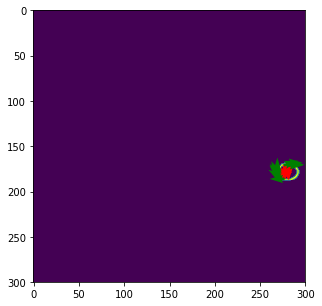

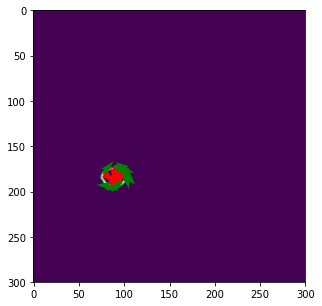

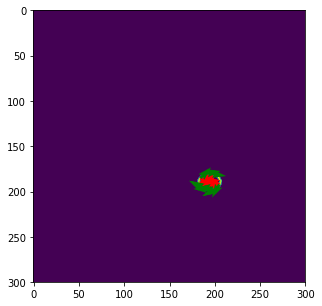

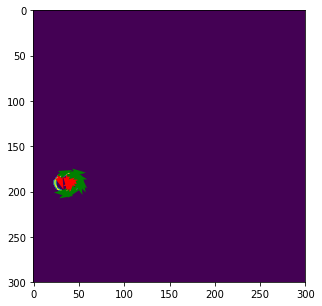

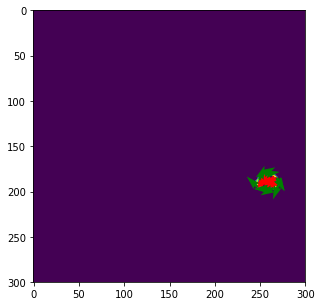

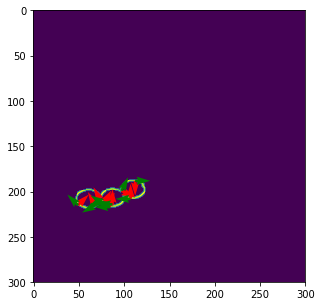

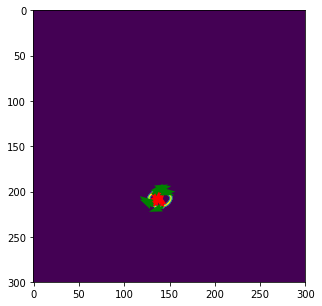

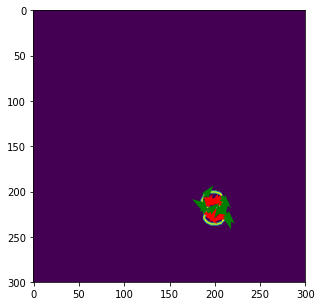

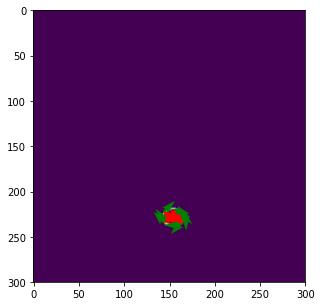

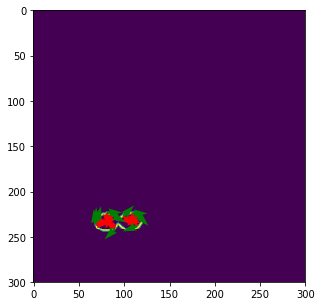

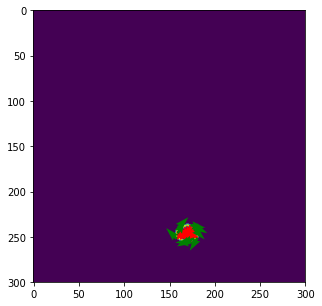

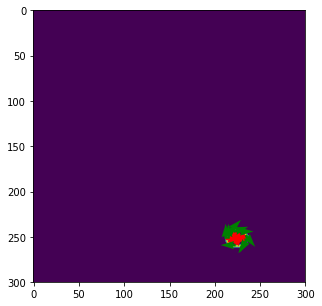

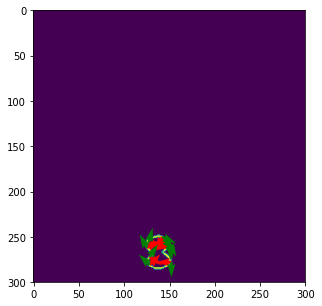

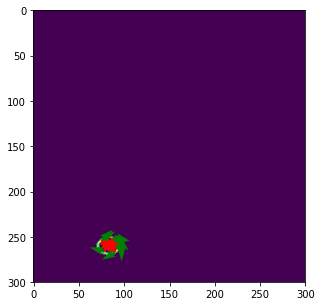

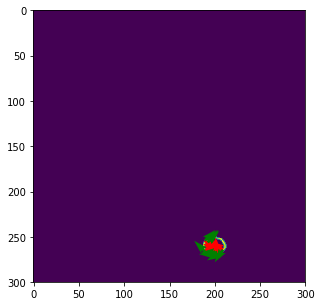

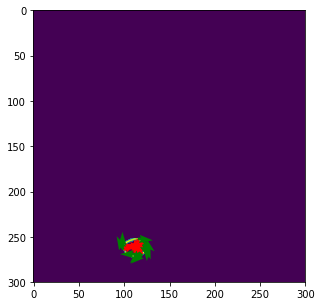

In [9]:
edgels = canny()
S = []
n = []
for i in range(len(masks)):  
    edgels = canny(h=3,w=3,th=.1)
    edgels.fit(1*masks[i][np.newaxis,np.newaxis,:,:],nonMaxSup=False)
    S.append(edgels.S)
    n.append(edgels.n)
    edgels.vector_field(figsize=(5,5),tan=True)
    plt.imshow(edgels.S)
    plt.show()

# Robust fitting

In [10]:
def circle_params(p):
    A,D,E,F = p
    xc = -D/(2*A)
    yc = -E/(2*A)
    R = np.sqrt(xc**2+yc**2-F/A)
    return R,np.array([xc,yc])
def circle_params_from_cart(xc,R):
    x,y = xc
    D = -2*x
    E = -2*y
    A = 1
    F = x**2+y**2-R**2
   
    return np.array([A,D,E,F])

def plot_circle_from_xk(xk,c='b'):
    plt.scatter(xk[1,:],xk[0,:],c=c,s=0.5)
    pass

def plot_circle_from_params(p,c='r'):
    R,xc = circle_params(p)
    teta = np.arange(0,2*np.pi,np.pi/36)
    xk = np.array([R*np.cos(teta),R*np.sin(teta)]) + xc[:,np.newaxis]
    plt.scatter(xk[0,:],xk[1,:],c=c,s=0.5)
    pass
    
def build_circle(R,xc,std=0,outliers=False,c='b',outliers_ratio=0.05,plot=True):
    noise = None
    
    teta = np.arange(0,2*np.pi,np.pi/36)
    xk = np.array([R*np.cos(teta),R*np.sin(teta)]) + xc[:,np.newaxis] + np.random.normal(0,std,(2,2*36))    
    
    if plot:plot_circle_from_xk(xk,c)
    if outliers:
        noise = np.array([0.5*R*np.cos(teta),0.5*R*np.sin(teta)]) + 0.5*R*xc[:,np.newaxis] + np.random.normal(0,std,(2,2*36))    
        #noise = np.random.normal(0,std,(2,int(outliers_ratio*72))) +2*xc[:,np.newaxis]+R
        if plot:plt.scatter(noise[0,:],noise[1,:],c='b')
        xk = np.hstack((xk,noise))
    return xk

In [43]:
import random
class random_cirles_from_edgels:
    def __init__(self,mask,n,th,lamb=10,ratio=(1,1)):
            
            self.saved = {'circles':[],'inliers':[],'nInliers':[]}
            self.n = n
            self.mask = mask.copy()
            
            row,col = np.argwhere(mask).T
            x=col
            y=row
            self.kps_bkup = self.kps = np.array([x,y])
                       
            nx = n[0,row,col]
            ny = n[1,row,col]
            d = -(nx*x+ny*y)*np.sqrt(nx**2+ny**2)
            
            
            self.ls = np.array([nx,ny,d])
                
            self.idx = np.arange(self.ls.shape[1])
            self.idx = np.random.permutation(self.idx)
            self.th = th
            self.lamb = lamb
            self.ratio=ratio
           
    def retain(self):
        self.saved['circles'].append(self.circles)
        self.saved['nInliers'].append(np.sum(self.inliers))
        self.saved['inliers'].append(self.inliers)
        pass
    
    def remove_kps(self,toremove):
        self.kps = self.kps[:,np.logical_not(toremove)]
        x,y = self.kps

        col=x
        row=y
        
        nx = self.n[0,row,col]
        ny = self.n[1,row,col]
        d = -(nx*x+ny*y)*np.sqrt(nx**2+ny**2)

        self.ls = np.array([nx,ny,d])

        self.idx = np.arange(self.ls.shape[1])
        self.idx = np.random.permutation(self.idx)
        self.saved = {'circles':[],'nInliers':[],'inliers':[]}
    
    def _next(self):      
        idx1 = np.random.choice(self.idx)
        self.l1 = self.ls[:,idx1]
        self.xk1 = self.kps[:,idx1]

        box,mask = get_box(self.xk1,self.lamb,self.kps,ratio=self.ratio)

        idx2 =np.random.choice(np.arange(box.shape[1]))
        self.l2 = self.ls[:,idx2]
        self.xk2 = self.kps[:,idx2]
        
        c = np.cross(self.l1,self.l2)
        
        c = c[:2]/c[2]
        
        
        nins = 0
        best_r=1
        best_inliers = box
        rr = np.sum((box-c[:,np.newaxis])**2,axis=0)
        for r in np.arange(3,15,3):           
            ek =(r**2 - rr)**2
            inliers = ek<self.th**2
            nInliers = np.sum(inliers)
            if nInliers > nins:
                best_r = r
                nins = nInliers
                #best_inliers = inliers
        
        rr = np.sum((self.kps-c[:,np.newaxis])**2,axis=0)
        ek = (best_r**2 - rr)**2
        inliers = ek<self.th**2
        self.circles = [c,best_r]
        self.inliers = inliers
        
        
        
        return np.sum(inliers)#best_inliers.shape[0]

In [12]:
def get_box(xk,lamb,kps,ratio=(1,1),plot=False):
    v = np.array(ratio)
    xmax,ymax = np.clip((xk+lamb*v),None,(np.max(kps,axis=1))).astype(np.int)
    xmin,ymin = np.clip((xk-lamb*v),0,None).astype(np.int)


    xbnd = (kps[0,:]>xmin)&(kps[0,:]<xmax)
    ybnd = (kps[1,:]>ymin)&(kps[1,:]<ymax)
    if plot==True:
        x,y = kps[:,xbnd&ybnd]
        plt.scatter(x,y,s=0.1)
        pass
    return kps[:,xbnd&ybnd],xbnd&ybnd

In [13]:
'''
p - probability of being an inlier
k - number of samples
S - number of required trials
'''
def RANSAC(obj,P=.99,p=.1,min_pts=2,minInliers=100):
    
    def get_S(p=.1,P=.99,min_pts=2):
        return np.round(np.log(1-P)/(np.log(1-p**min_pts))).astype(int)

    S = get_S(p,P,min_pts)

    for i in range(S):
        nInliers = obj._next()
        
        if minInliers<nInliers:
            obj.retain()
            if minInliers>1000:
                break
                
    return obj.saved

In [14]:
def bestProposal(kps,circles,sig):
    A = build_data_matrix(kps)
    o = []
    for t,par in enumerate(circles['circles']):
        xc,R = par
        p = circle_params_from_cart(xc,R)
       
        ek = A.T.dot(p)
        w = 2*sig**2/(sig**2+ek**2)**2
        
        #o.append(int(np.sum((ek**2)/(sig**2+ek**2)))/(1+circles['nInliers'][t]))
        o.append(np.sum(w)/circles['nInliers'][t])
    best_proposals = np.argsort(o)
    
    for key in circles.keys():
        circles[key] = [circles[key][i] for i in best_proposals]
    
    return circles

In [15]:
norm= lambda x: (x-x.min())/(x.max()-x.min())

In [16]:
def build_data_matrix(xk):
    z = np.sum(xk**2,axis=0)
    ones = np.ones(z.shape)
    Z = np.vstack((z,xk,ones))  
    return Z

In [17]:
def fit_circle(w,Z):

    s = np.sum(w)

    M = (1/s)*(w*Z).dot(Z.T)

    N = np.array([[0,0,0,-2],[0,1,0,0],[0,0,1,0],[-2,0,0,0]])

    N_inv = np.array([[0,0,0,-1/2],[0,1,0,0],[0,0,1,0],[-1/2,0,0,0]])

    U,S,V = np.linalg.svd(N_inv.dot(M))

    return V[-1,:]

In [49]:
class circle_fitting:
    def __init__(self,xk=None,p=None,sig=1,autosig=False):
        
        self.xk = xk
        self.p=p
        self.K = xk.shape[1]
        self.Z = build_data_matrix(xk)
        if autosig:
            self.sig = np.std(self.ek())
        else:
            self.sig = sig
            
    
    def plot(self,title='fitted_circle'):
        
        plot_circle_from_params(self.p,c='r')
        #plt.scatter(self.xk[1,:],self.xk[0,:],c='r',s=1)
                
    
    def weights(self,ek):
        return (2*self.sig**2)/(ek**2+self.sig**2)**2  
    
    def fit_irls(self):
        
        ek = self.Z.T.dot(self.p)        
        w = self.weights(ek)
        for i in range(3):
            p = fit_circle(w=w,Z=self.Z)
            ek = self.Z.T.dot(p)
            w = self.weights(ek)
            #plt.hist(w)
        self.p =p
        self.w=w
        
        
    def inliers(self,th=0.6):
        
        #o = self.rho_gm()
        return norm(self.w)>0.36#o<th
        
    
    def ek(self):
        return self.Z.T.dot(self.p)
    
    def rho_gm(self):
        ek = self.ek()
        return ek**2/(ek**2+self.sig**2)
     
    
    def crt(self):
        print('--Objective:{} --K:{}'.format(np.sum(self.rho_gm()),self.K))
    
    
    def plot_error(self,title='objective versus error_plot'):
        plt.title(title)
        plt.scatter(circle.ek(),circle.rho_gm())
        
    def plot_support(self):
        x,y = self.xk
        support= self.inliers()
        plt.scatter(x,y,c=support,s=1)
        

In [19]:
import time

/home/robinson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/home/robinson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/home/robinson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in less
/home/robinson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in less


25.20043921470642


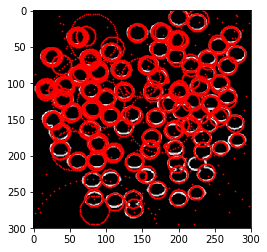

In [52]:
start=time.time()
plt.figure()
#plt.imshow(S[0],**{'cmap':'gray'})
for nn in np.arange(len(masks)-1):
    nn+=1
    random_circles = random_cirles_from_edgels(1*S[nn],n[nn],th=85,lamb=80,ratio=(1,1))
    nKps0=random_circles.kps.shape[1]                                                   
    #plt.figure()
    while True:
        
        try:
            circles = RANSAC(random_circles,P=.99,p=.1,min_pts=2,minInliers=200)
            best_circles = bestProposal(random_circles.kps,circles,1)
        
            xc,R = best_circles['circles'][-1]

            p = circle_params_from_cart(xc,R)
            
            circle = circle_fitting(random_circles.kps,sig=.0002,p=p)
            circle.fit_irls()

            #plot_circle_from_params(p,c='b')
               
            
            #plt.title(str(np.sum(circle.rho_gm())))
            #circle.plot_support()
            circle.plot()
            #circle.plot_error()
            #plt.title(str(nn))
            #plt.imshow(masks[nn],**{'cmap':'gray'})
            #plt.show()
            #np.abs(circle.ek())<1.5# circle.inliers(p)
            
            #print(nn,random_circles.kps.shape,np.sum(circle.rho_gm()))
            remove = circle.inliers()#best_circles['inliers'][0] linux.
            #print(np.sum(remove))
            random_circles.remove_kps(remove)
            
            if random_circles.kps.shape[1]<0.3*nKps0:
                break
            '''
                remove = circles.inliers()#best_circles['inliers'][0]
                random_circles.remove_kps(remove)
            else:
                print("kps<{}".format(0.1*nKps0))
                break
            '''
        except Exception as e:
            #print(e)
            break
plt.imshow(S[0],**{'cmap':'gray'})
           
end = time.time()
print((end -start))

True False


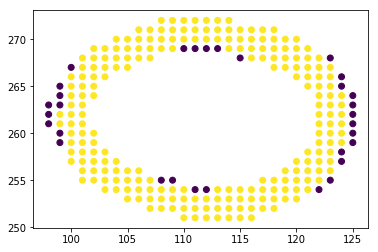

In [45]:
x,y = circle.xk
support=norm(circle.w)>0.5
plt.scatter(x,y,c=support)
#plt.imshow(S[0])
print(support.max(),support.min())

9.155565136871257


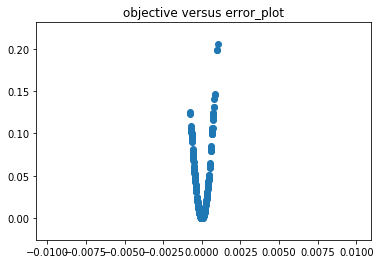

In [41]:
circle.plot_error()
print(np.sum(circle.rho_gm()))

499172.50385897135


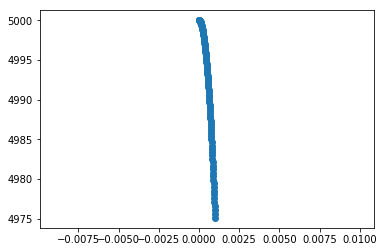

In [23]:
sig=0.02
e=np.linspace(-1e-5,1e-3,100)
rho=lambda e:(e**2)/(sig**2+e**2)
w=lambda e:2*sig**2/(sig**2+e**2)**2

plt.scatter(e,w(e))
print(np.sum(w(e)))

In [24]:
circle.w.min(),circle.w.max()

(2217.221270179829, 2222.222214783914)

In [25]:
circle.ek().min()

-0.0007573002350000912